# 0. Getting started with CapyMOA

This notebook shows some basic usage of CapyMOA for supervised learning (classification and regression).

* There are more detailed notebooks and documentation available; our goal here is just to present some high-level functions and demonstrate a subset of CapyMOA's functionalities.
* For simplicity, we simulate data streams in the following examples using datasets and employing synthetic generators. One could also read data directly from a CSV or ARFF (See [stream_from_file](https://capymoa.org/api/modules/capymoa.stream.html#capymoa.stream.stream_from_file) function).

---

*More information about CapyMOA can be found at* https://www.capymoa.org

**last update on 12/11/2025**

## 1. Classification

* Classification for data streams traditionally assumes instances are available
  to the classifier in an incremental fashion and labels become available before
  a new instance becomes available.
* It is common to simulate this behavior using a **while loop**, often referred
  to as a **test-then-train loop** which contains 4 distinct steps:
    1. Fetches the next instance from the stream
    2. Makes a prediction
    3. Train the model with the instance
    4. Update a mechanism to keep track of metrics

**Some remarks about the test-then-train loop**:

* We must not train before testing, meaning that steps 2 and 3 should not be interchanged, as this would invalidate our interpretation concerning how the model performs on unseen data, leading to unreliable evaluations of its efficacy. 
* Steps 3 and 4 can be completed in any order without altering the result. 
* What if labels are not immediately available? Then you might want to read about delayed labeling and partially labeled data, see [A Survey on Semi-supervised Learning for Delayed Partially Labelled Data Streams](https://dl.acm.org/doi/full/10.1145/3523055)
* More information on classification for data streams is available at section **2.2 Classification** from the [Machine Learning for Data Streams](https://moa.cms.waikato.ac.nz/book-html/) book


In [1]:
# This cell is hidden on capymoa.org. See docs/contributing/docs.rst
from util.nbmock import mock_datasets, is_nb_fast

if is_nb_fast():
    mock_datasets()

In [2]:
from capymoa.datasets import Electricity
from capymoa.evaluation import ClassificationEvaluator
from capymoa.classifier import OnlineBagging

elec_stream = Electricity()
ob_learner = OnlineBagging(schema=elec_stream.get_schema(), ensemble_size=5)
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

for instance in elec_stream:
    prediction = ob_learner.predict(instance)
    ob_learner.train(instance)
    ob_evaluator.update(instance.y_index, prediction)

print(ob_evaluator.accuracy())

82.06656073446328


### 1.1 High-level evaluation functions

* If our goal is just to evaluate learners, it would be tedious to keep writing **test-then-train loops**. 
Thus, it makes sense to encapsulate that loop inside **high-level evaluation functions**. 

* Furthermore, sometimes we are interested in **cumulative metrics** and sometimes we care about **windowed metrics**. For example, if we want to know how accurate our model is so far, considering all the instances it has seen, then we would look at its **cumulative metrics**. However, we might also be interested in how well the model is performing every **n** number of instances, so that we can, for example, identify periods in which our model was really struggling to produce correct predictions. 

* In this example, we use the ```prequential_evaluation``` function, which provides us with both the cumulative and the windowed metrics! 

* Some remarks:
    * If you want to know more about other **high-level evaluation functions**, **evaluators**, or which **metrics** are available, check the **01_evaluation** notebook.
    * The **results** from evaluation functions such as **prequential_evaluation** follow a standard and are discussed thoroughly in the **Evaluation documentation** at http://www.capymoa.org.
    * Sometimes authors refer to the **cumulative** metrics as **test-then-train** metrics, such as **test-then-train accuracy** (or TTT accuracy for short). They all refer to the same concept.
    * Shouldn't we recreate the stream object ```elec_stream```? No, `prequential_evaluation()`, by default, will automatically ```restart()``` streams when they are reused.

In the below example `prequential_evaluation` is used with a `HoeffdingTree` classifier on the `Electricity` data stream.

In [3]:
from capymoa.evaluation import prequential_evaluation
from capymoa.classifier import HoeffdingTree

ht = HoeffdingTree(schema=elec_stream.get_schema(), grace_period=50)

# Obtain the results from the high-level function.
# Note that we need to specify a window_size as we obtain both windowed and cumulative results.
# The results from a high-level evaluation function are represented as a PrequentialResults object.
results_ht = prequential_evaluation(stream=elec_stream, learner=ht, window_size=4500)

print(
    f"Cumulative accuracy = {results_ht.cumulative.accuracy()}, wall-clock time: {results_ht.wallclock()}"
)

# The windowed results are conveniently stored in a pandas DataFrame.
display(results_ht.windowed.metrics_per_window())

Cumulative accuracy = 81.6604872881356, wall-clock time: 0.4376184940338135


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,4500.0,87.777778,74.440796,24.242424,68.856172,87.222016,84.550562,89.889706,87.149807,84.078212,90.221402,87.294344,85.028249,89.560440
1,9000.0,83.666667,66.963969,2.649007,64.458414,83.538542,81.657100,85.279391,83.752489,84.373388,83.131589,83.325685,79.110251,87.541118
2,13500.0,85.644444,71.282626,2.269289,70.009285,85.663875,85.304823,85.968723,85.634554,83.780161,87.488948,85.693216,86.886006,84.500427
3,18000.0,81.977778,61.953129,-25.154321,57.021728,81.463331,76.168087,85.510095,82.841248,85.488127,80.194370,80.130502,68.680445,91.580559
4,22500.0,86.177778,70.202882,13.370474,64.719229,85.389296,80.931944,89.159986,86.648480,88.058706,85.238254,84.166185,74.872377,93.459993
5,27000.0,78.088889,53.951820,-72.377622,47.272727,77.186522,71.634062,82.150615,77.962693,77.521793,78.403594,76.425652,66.577540,86.273764
6,31500.0,79.066667,55.619360,-71.897810,46.263548,77.829775,72.504378,83.100108,78.081099,74.237896,81.924301,77.580064,70.849971,84.310157
7,36000.0,74.955556,49.002474,-89.411765,37.354086,74.661963,70.719667,78.120753,74.256346,66.390244,82.122449,75.072035,75.653141,74.490929
8,40500.0,74.555556,50.130218,-71.664168,41.312148,76.116886,74.818562,74.286998,76.196815,65.523883,86.869748,76.037125,87.186058,64.888191
9,45000.0,84.377778,68.535062,-0.428571,68.390288,84.268304,82.949309,85.585401,84.249034,82.648623,85.849445,84.287584,83.252191,85.322976


### 1.2 Comparing results among classifiers

* CapyMOA provides ```plot_windowed_results``` as an easy visualisation function for quickly comparing **windowed metrics**.
* In the example below, we create three classifiers: HoeffdingAdaptiveTree, HoeffdingTree and AdaptiveRandomForest, and plot the results using ```plot_windowed_results```.
* More details about ```plot_windowed_results``` options are described in the documentation at http://www.capymoa.org.

HAT accuracy = 84.68617584745762
HT accuracy = 81.6604872881356
ARF accuracy = 89.32953742937853


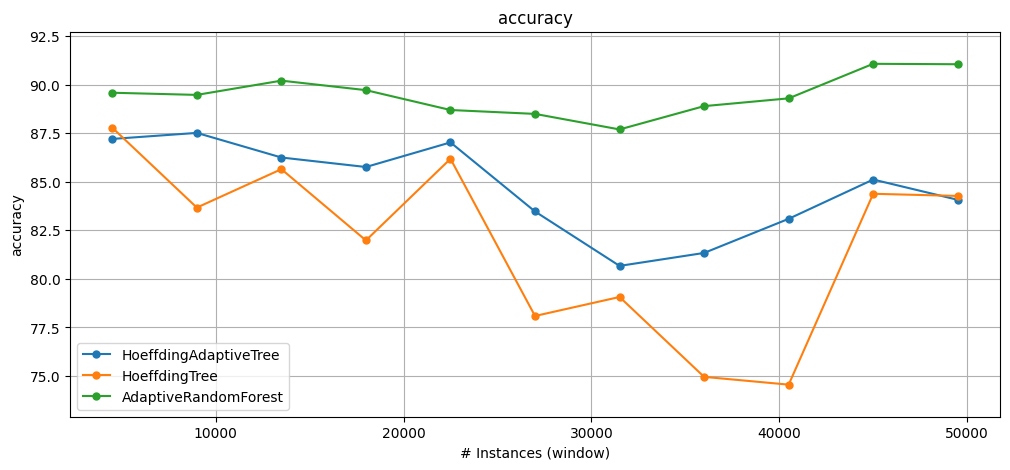

In [4]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.base import MOAClassifier
from moa.classifiers.trees import HoeffdingAdaptiveTree
from capymoa.classifier import HoeffdingTree
from capymoa.classifier import AdaptiveRandomForestClassifier

# Create the wrapper for HoeffdingAdaptiveTree (from MOA).
HAT = MOAClassifier(
    schema=elec_stream.get_schema(), moa_learner=HoeffdingAdaptiveTree, CLI="-g 50"
)
HT = HoeffdingTree(schema=elec_stream.get_schema(), grace_period=50)
ARF = AdaptiveRandomForestClassifier(
    schema=elec_stream.get_schema(), ensemble_size=10, number_of_jobs=4
)

results_HAT = prequential_evaluation(stream=elec_stream, learner=HAT, window_size=4500)
results_HT = prequential_evaluation(stream=elec_stream, learner=HT, window_size=4500)
results_ARF = prequential_evaluation(stream=elec_stream, learner=ARF, window_size=4500)

# Comparing models based on their cumulative accuracy.
print(f"HAT accuracy = {results_HAT.cumulative.accuracy()}")
print(f"HT accuracy = {results_HT.cumulative.accuracy()}")
print(f"ARF accuracy = {results_ARF.cumulative.accuracy()}")

# Plotting the results. Note that we ovewrote the ylabel, but that doesn't change the metric.
plot_windowed_results(
    results_HAT,
    results_HT,
    results_ARF,
    metric="accuracy",
    xlabel="# Instances (window)",
)

## 2. Regression

* Regression algorithms have APIs very similar to classification algorithms. We can use the same high-level evaluation and visualisation functions for regression and classification.
* Similar to classification, we can also use MOA objects through a generic API.

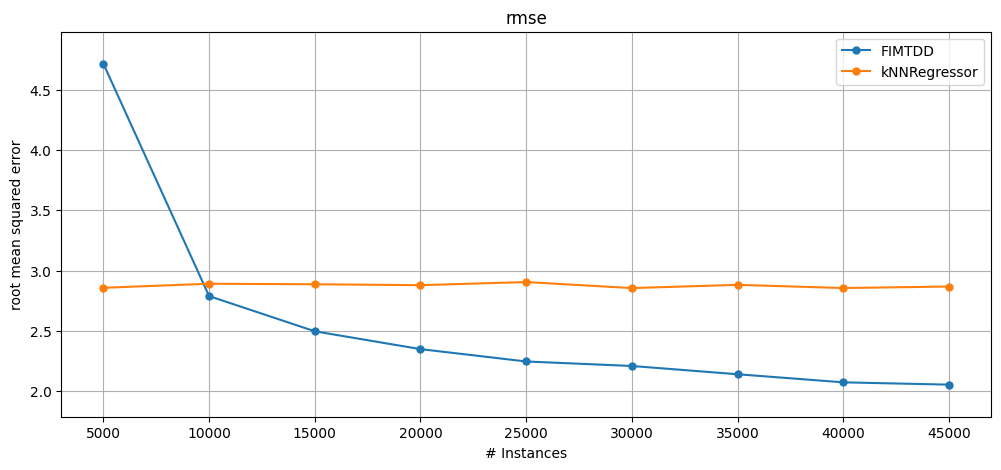

In [5]:
from capymoa.datasets import Fried
from moa.classifiers.trees import FIMTDD
from capymoa.base import MOARegressor
from capymoa.regressor import KNNRegressor

fried_stream = (
    Fried()
)  # Downloads the Fried dataset into the data dir in case it is not there yet.
fimtdd = MOARegressor(schema=fried_stream.get_schema(), moa_learner=FIMTDD())
knnreg = KNNRegressor(schema=fried_stream.get_schema(), k=3, window_size=1000)

results_fimtdd = prequential_evaluation(
    stream=fried_stream, learner=fimtdd, window_size=5000
)
results_knnreg = prequential_evaluation(
    stream=fried_stream, learner=knnreg, window_size=5000
)

results_fimtdd.windowed.metrics_per_window()
# Note that the metric is different from the ylabel parameter, which just overrides the y-axis label.
plot_windowed_results(
    results_fimtdd, results_knnreg, metric="rmse", ylabel="root mean squared error"
)

## 3. Concept Drift

* One of the most challenging and defining aspects of data streams is the phenomenon known as **concept drifts**.
* In CapyMOA, we designed the simplest and most complete API for simulating, visualising and assessing concept drifts.
* In the example below, we focus on a simple way of simulating and visualising a drifting stream. There is a tutorial focusing entirely on how concept drift can be simulated, detected and assessed in a separate notebook (See **Tutorial 4**: `Simulating Concept Drifts with the DriftStream API`).

### 3.1 Plotting Drift Detection results

* This example uses the DriftStream building API, precisely the **positional version** where drifts are specified according to their exact location in the stream.
* **Integration with the visualisation function.** The DriftStream object carries meta-information about the drift which is passed along the stream and thus becomes available to ```plot_windowed_results```.

* The following plot contains two drifts: 1 abrupt and 1 gradual, such that the abrupt drift is located at instance 5000 and the gradual drift starts at instance 9000 and ends at 12000. This information is provided to the stream via ```GradualDrift(start=9000, end=12000)```.

* More details concerning concept drifts in CapyMOA can be found in the documentation at http://www.capymoa.org.

None


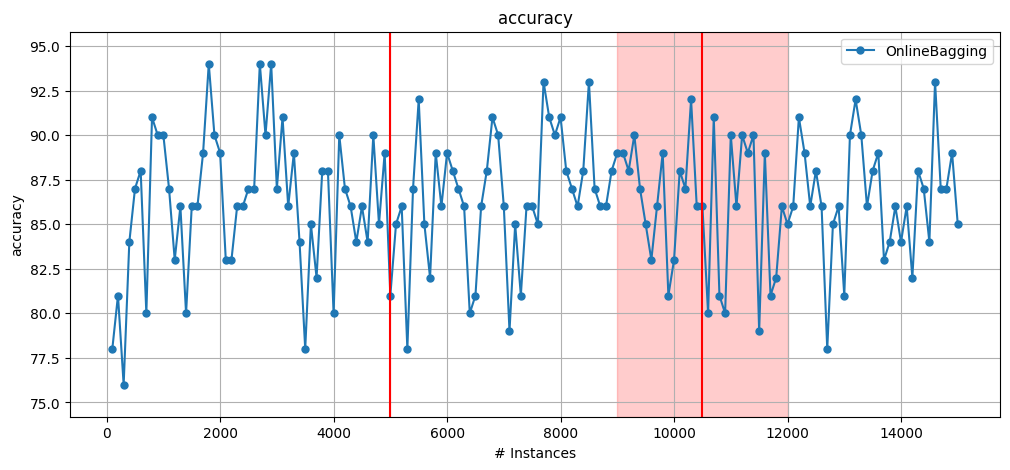

In [6]:
from capymoa.classifier import OnlineBagging
from capymoa.stream.generator import SEA
from capymoa.stream.drift import AbruptDrift, GradualDrift, DriftStream

# Generating a synthetic stream with 1 abrupt drift and 1 gradual drift.
stream_sea2drift = DriftStream(
    stream=[
        SEA(function=1),
        AbruptDrift(position=5000),
        SEA(function=3),
        GradualDrift(start=9000, end=12000),
        SEA(function=1),
    ]
)

OB = OnlineBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10)

# Since this is a synthetic stream, max_instances is needed to determine the amount of instances to be generated.
results_sea2drift_OB = prequential_evaluation(
    stream=stream_sea2drift, learner=OB, window_size=100, max_instances=15000
)

plot_windowed_results(results_sea2drift_OB, metric="accuracy")